In [82]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

This notebook reads the data in pdiot_data/2021, removes recordings that are too small, and creates sliding windows of the recordings. These are then saved into ../data/sliding_windows_sizeX_stepX

## Getting the data

In [98]:
data_path = '../pdiot-data/2021/'
sensor='Thingy'

In [99]:
base_df = pd.DataFrame()

# Get a list of all respeck files in all the student folders
all_files = []
for f in os.listdir(data_path):
    if os.path.isdir(data_path + '/' + f):
        files = os.listdir(data_path + '/' + f)
        files = [data_path + '/' + f + '/' + f2 for f2 in files if sensor in f2]
        all_files += files
        
# Load them all into a df
for filename in all_files:
    #full_path = f"{clean_data_folder}/{filename}"
    #print(full_path)
    
    # load data into a DataFrame
    new_df = pd.read_csv(filename)
    
    # merge into the base DataFrame
    base_df = pd.concat([base_df, new_df])

In [100]:
# We want to remove any falling recordings over 700 datapoints as this suggests that it contains falling + getting up
# We also want to remove any recordings less than the window size

In [118]:
smallest_window_size = 20
s = base_df.groupby('recording_id').size() >= smallest_window_size

filtered_df = base_df[base_df['recording_id'].isin(s.keys()[s])]

# One Thingy recording has a bunch of NAN
filtered_df = filtered_df[filtered_df['recording_id'] != 'Thingy_s1817455_Falling on the left_29-09-2021_16-13-56']

# Remove falling recordings longer than 700
s = filtered_df[filtered_df['activity_type'].str.contains('Falling')].groupby('recording_id').size() >= 700

filtered_df = filtered_df[~filtered_df['recording_id'].isin(s.keys()[s])]

# s1702583 has really inconsistent activity naming - remove
filtered_df = filtered_df[filtered_df['subject_id'] != 's1702583']

In [119]:
# Check that other people named correctly
filtered_df[filtered_df.apply(lambda x: not(x.activity_type in x.recording_id or x.activity_type.replace(' ', '_') in x.recording_id), axis=1)]

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id,Unnamed: 0


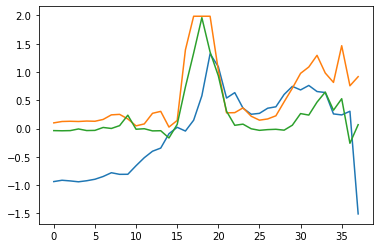

In [120]:
def plot_by_id(i): 
    plot_recording = base_df[base_df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
plot_by_id('Thingy_s1817455_Falling on the left_29-09-2021_16-13-56')

In [123]:
#base_df[base_df['activity_type'] == "Falling on the back"].groupby('recording_id').size().sort_values().head(40)
filtered_df.groupby('recording_id').size().sort_values().tail(40)

recording_id
Thingy_s1724279_Descending stairs_29-09-2021_13-04-35        770
Thingy_s1757177_Sitting_02-10-2021_13-39-40                  770
Thingy_s2250677_Lying down left_06-10-2021_13-36-02          770
Thingy_s1850642_Sitting_29-09-2021_12-49-46                  770
Thingy_s1850642_Sitting bent forward_29-09-2021_13-15-41     770
Thingy_s1850642_Sitting bent backward_29-09-2021_13-16-26    770
Thingy_s2250677_Sitting_06-10-2021_13-31-43                  770
Thingy_s1850642_Running_29-09-2021_13-24-04                  770
Thingy_s1850642_Movement_29-09-2021_13-27-54                 770
Thingy_s1850642_Lying down right_29-09-2021_13-20-04         770
Thingy_s1850642_Lying down left_29-09-2021_13-18-56          770
Thingy_s1850642_Lying down on back_29-09-2021_13-18-10       770
Thingy_s1850642_Lying down on stomach_29-09-2021_13-20-54    770
Thingy_s2181154_Desk work_03-10-2021_17-10-22                771
Thingy_s1718069_Lying down on back_04-10-2021_14-08-48       771
Thingy_s2173

## Preparing the sliding windows

In [124]:
filtered_df['activity_type'].unique()

array(['Climbing stairs', 'Descending stairs', 'Desk work',
       'Falling on knees', 'Falling on the back', 'Falling on the left',
       'Falling on the right', 'Lying down left', 'Lying down on back',
       'Lying down on stomach', 'Lying down right', 'Movement', 'Running',
       'Sitting bent backward', 'Sitting bent forward', 'Sitting',
       'Standing', 'Walking at normal speed'], dtype=object)

In [125]:
#activities_of_interest = ['Standing', 'Walking at normal speed']
activities_of_interest = filtered_df['activity_type'].unique()

In [126]:
window_size = smallest_window_size # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = smallest_window_size # 25 is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in filtered_df.groupby("recording_id"):
    if group['activity_type'].iloc[0] in activities_of_interest:
    
        print(f"Processing rid = {rid}")

        large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

        overlapping_windows = large_enough_windows[::step_size] 

        # then we will append a window ID to each window
        for window in overlapping_windows:
            window.loc[:, 'window_id'] = window_number
            window_number += 1

        #print(overlapping_windows)

        all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

Processing rid = Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07
Processing rid = Thingy_s1541031_Descending stairs_06-10-2021_11-26-27


C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Processing rid = Thingy_s1541031_Desk work_06-10-2021_11-09-15
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-22-46
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-22-51
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-22-56
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-02
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-08
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-14
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-21
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-29
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-35
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-41
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-48
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-54
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-24-00
Processing rid = Thingy_s15

Processing rid = Thingy_s1704145_Falling on the right_05-10-2021_12-42-32
Processing rid = Thingy_s1704145_Falling on the right_05-10-2021_12-42-45
Processing rid = Thingy_s1704145_Falling on the right_05-10-2021_12-42-54
Processing rid = Thingy_s1704145_Lying down left_23-09-2021_10-51-25
Processing rid = Thingy_s1704145_Lying down on back_23-09-2021_10-53-38
Processing rid = Thingy_s1704145_Lying down on stomach_23-09-2021_10-52-56
Processing rid = Thingy_s1704145_Lying down right_23-09-2021_10-52-12
Processing rid = Thingy_s1704145_Movement_23-09-2021_11-00-02
Processing rid = Thingy_s1704145_Running_23-09-2021_11-11-04
Processing rid = Thingy_s1704145_Sitting bent backward_23-09-2021_10-49-34
Processing rid = Thingy_s1704145_Sitting bent forward_05-10-2021_18-32-50
Processing rid = Thingy_s1704145_Sitting_23-09-2021_10-45-49
Processing rid = Thingy_s1704145_Standing_23-09-2021_10-50-24
Processing rid = Thingy_s1704145_Walking at normal speed_23-09-2021_11-08-53
Processing rid = Thi

Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-47-08
Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-47-14
Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-47-20
Processing rid = Thingy_s1711661_Lying down left_23-09-2021_20-11-06
Processing rid = Thingy_s1711661_Lying down on back_23-09-2021_20-08-09
Processing rid = Thingy_s1711661_Lying down on stomach_23-09-2021_20-16-07
Processing rid = Thingy_s1711661_Lying down right_23-09-2021_20-13-32
Processing rid = Thingy_s1711661_Movement_23-09-2021_21-11-35
Processing rid = Thingy_s1711661_Running_23-09-2021_20-45-32
Processing rid = Thingy_s1711661_Sitting bent backward_23-09-2021_19-57-28
Processing rid = Thingy_s1711661_Sitting bent forward_23-09-2021_19-54-57
Processing rid = Thingy_s1711661_Sitting_23-09-2021_19-52-42
Processing rid = Thingy_s1711661_Standing_23-09-2021_19-59-54
Processing rid = Thingy_s1711661_Walking at normal speed_23-09-2021_20-25-00
Processing rid = Thi

Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-03
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-12
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-24
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-33
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-42
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-50
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-59
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-51-07
Processing rid = Thingy_s1724067_Desk work_06-10-2021_20-24-14
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-16
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-20
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-25
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-30
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-34
Processing rid = Th

Processing rid = Thingy_s1724067_Lying down on stomach_06-10-2021_20-19-55
Processing rid = Thingy_s1724067_Lying down right_06-10-2021_20-18-42
Processing rid = Thingy_s1724067_Movement_06-10-2021_20-23-00
Processing rid = Thingy_s1724067_Running_06-10-2021_19-56-22
Processing rid = Thingy_s1724067_Sitting bent backward_06-10-2021_20-06-11
Processing rid = Thingy_s1724067_Sitting bent forward_06-10-2021_20-07-11
Processing rid = Thingy_s1724067_Sitting_06-10-2021_20-05-12
Processing rid = Thingy_s1724067_Standing_06-10-2021_20-11-25
Processing rid = Thingy_s1724067_Walking at normal speed_06-10-2021_19-53-02
Processing rid = Thingy_s1724279_Climbing stairs_29-09-2021_13-03-42
Processing rid = Thingy_s1724279_Descending stairs_29-09-2021_13-04-35
Processing rid = Thingy_s1724279_Desk work_06-10-2021_12-35-04
Processing rid = Thingy_s1724279_Falling on knees_06-10-2021_11-53-09
Processing rid = Thingy_s1724279_Falling on knees_06-10-2021_11-53-12
Processing rid = Thingy_s1724279_Falling

Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-52-57
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-53-05
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-53-13
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-53-22
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-53-29
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-53-38
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-53-56
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-54-05
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-54-13
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-54-22
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-54-31
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-54-39
Processing rid = Thingy_s1727780_Falling on the left_29-09-2021_21-54-52
Processing rid = Thingy_s1727780_Falling on the rig

Processing rid = Thingy_s1732873_Lying down right_04-10-2021_13-47-28
Processing rid = Thingy_s1732873_Movement_04-10-2021_16-11-41
Processing rid = Thingy_s1732873_Running_04-10-2021_15-36-19
Processing rid = Thingy_s1732873_Sitting bent backward_04-10-2021_13-44-31
Processing rid = Thingy_s1732873_Sitting bent forward_04-10-2021_13-43-53
Processing rid = Thingy_s1732873_Sitting_04-10-2021_13-42-27
Processing rid = Thingy_s1732873_Standing_04-10-2021_13-45-11
Processing rid = Thingy_s1732873_Walking at normal speed_04-10-2021_15-31-05
Processing rid = Thingy_s1757177_Climbing stairs_06-10-2021_16-35-56
Processing rid = Thingy_s1757177_Descending stairs_06-10-2021_16-35-09
Processing rid = Thingy_s1757177_Desk work_02-10-2021_13-48-52
Processing rid = Thingy_s1757177_Falling on knees_06-10-2021_08-32-51
Processing rid = Thingy_s1757177_Falling on knees_06-10-2021_08-32-58
Processing rid = Thingy_s1757177_Falling on knees_06-10-2021_08-33-04
Processing rid = Thingy_s1757177_Falling on k

Processing rid = Thingy_s1761322_Lying down on stomach_27-09-2021_11-02-21
Processing rid = Thingy_s1761322_Lying down right_27-09-2021_11-03-27
Processing rid = Thingy_s1761322_Movement_27-09-2021_12-30-53
Processing rid = Thingy_s1761322_Running_27-09-2021_13-12-47
Processing rid = Thingy_s1761322_Sitting bent backward_27-09-2021_10-49-18
Processing rid = Thingy_s1761322_Sitting bent forward_27-09-2021_10-47-52
Processing rid = Thingy_s1761322_Sitting_27-09-2021_10-43-28
Processing rid = Thingy_s1761322_Standing_27-09-2021_10-42-16
Processing rid = Thingy_s1761322_Walking at normal speed_27-09-2021_13-02-07
Processing rid = Thingy_s1800883_Climbing stairs_29-09-2021_12-48-01
Processing rid = Thingy_s1800883_Descending stairs_29-09-2021_12-48-59
Processing rid = Thingy_s1800883_Desk work_29-09-2021_11-38-37
Processing rid = Thingy_s1800883_Falling on knees_29-09-2021_14-54-21
Processing rid = Thingy_s1800883_Falling on knees_29-09-2021_14-54-25
Processing rid = Thingy_s1800883_Falling

Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-07
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-12
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-17
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-22
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-27
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-32
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-36
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-40
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-45
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-49
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-54
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-04-59
Processing rid = Thingy_s1801931_Falling on the right_06-10-2021_00-05-04
Processing rid = Thingy_s1801931_Falli

Processing rid = Thingy_s1813106_Lying down right_07-10-2021_19-23-08
Processing rid = Thingy_s1813106_Movement_07-10-2021_21-09-55
Processing rid = Thingy_s1813106_Running_07-10-2021_23-18-28
Processing rid = Thingy_s1813106_Sitting bent backward_07-10-2021_18-26-02
Processing rid = Thingy_s1813106_Sitting bent forward_07-10-2021_18-25-19
Processing rid = Thingy_s1813106_Sitting_07-10-2021_18-24-30
Processing rid = Thingy_s1813106_Standing_07-10-2021_18-27-24
Processing rid = Thingy_s1813106_Walking at normal speed_07-10-2021_23-17-32
Processing rid = Thingy_s1817455_Climbing stairs_29-09-2021_15-04-00
Processing rid = Thingy_s1817455_Climbing stairs_29-09-2021_15-05-04
Processing rid = Thingy_s1817455_Climbing stairs_29-09-2021_15-39-30
Processing rid = Thingy_s1817455_Climbing stairs_29-09-2021_15-39-49
Processing rid = Thingy_s1817455_Descending stairs_29-09-2021_15-04-18
Processing rid = Thingy_s1817455_Descending stairs_29-09-2021_15-05-17
Processing rid = Thingy_s1817455_Descend

Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-26
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-29
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-33
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-36
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-39
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-42
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-46
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-49
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-52
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-55
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-50-58
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-51-01
Processing rid = Thingy_s1817972_Falling on the right_06-10-2021_20-51-04
Processing rid = Thingy_s1817972_Falli

Processing rid = Thingy_s1823274_Desk work_04-10-2021_13-42-57
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-19-38
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-19-49
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-19-59
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-20-08
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-20-15
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-20-21
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-20-29
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-20-35
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-20-49
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-20-56
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-21-02
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-21-11
Processing rid = Thingy_s1823274_Falling on knees_04-10-2021_15-21-18
Processing rid = Thingy_s18

Processing rid = Thingy_s1824891_Lying down on stomach_06-10-2021_16-52-08
Processing rid = Thingy_s1824891_Lying down right_06-10-2021_16-50-37
Processing rid = Thingy_s1824891_Movement_06-10-2021_16-53-56
Processing rid = Thingy_s1824891_Running_06-10-2021_17-05-08
Processing rid = Thingy_s1824891_Sitting bent backward_06-10-2021_16-42-50
Processing rid = Thingy_s1824891_Sitting bent forward_06-10-2021_16-41-35
Processing rid = Thingy_s1824891_Sitting_08-10-2021_15-28-19
Processing rid = Thingy_s1824891_Standing_07-10-2021_22-16-27
Processing rid = Thingy_s1824891_Walking at normal speed_06-10-2021_17-00-34
Processing rid = Thingy_s1826390_Climbing stairs_07-10-2021_20-39-45
Processing rid = Thingy_s1826390_Descending stairs_07-10-2021_20-38-44
Processing rid = Thingy_s1826390_Desk work_07-10-2021_18-49-20
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-25
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-28
Processing rid = Thingy_s1826390_Falling

Processing rid = Thingy_s1841064_Falling on the right_04-10-2021_15-11-39
Processing rid = Thingy_s1841064_Lying down left_06-10-2021_13-07-16
Processing rid = Thingy_s1841064_Lying down on back_04-10-2021_13-58-28
Processing rid = Thingy_s1841064_Lying down on stomach_04-10-2021_14-01-16
Processing rid = Thingy_s1841064_Lying down right_04-10-2021_14-00-22
Processing rid = Thingy_s1841064_Movement_04-10-2021_14-02-16
Processing rid = Thingy_s1841064_Running_04-10-2021_14-25-59
Processing rid = Thingy_s1841064_Sitting bent backward_06-10-2021_14-58-26
Processing rid = Thingy_s1841064_Sitting bent forward_04-10-2021_13-54-07
Processing rid = Thingy_s1841064_Sitting_06-10-2021_15-01-31
Processing rid = Thingy_s1841064_Standing_06-10-2021_15-02-23
Processing rid = Thingy_s1841064_Walking at normal speed_04-10-2021_14-25-17
Processing rid = Thingy_s1842093_Climbing stairs_06-10-2021_11-12-12
Processing rid = Thingy_s1842093_Descending stairs_06-10-2021_11-13-34
Processing rid = Thingy_s184

Processing rid = Thingy_s1842093_Falling on the right_05-10-2021_22-10-44
Processing rid = Thingy_s1842093_Falling on the right_05-10-2021_22-10-49
Processing rid = Thingy_s1842093_Falling on the right_05-10-2021_22-10-53
Processing rid = Thingy_s1842093_Falling on the right_05-10-2021_22-10-59
Processing rid = Thingy_s1842093_Falling on the right_05-10-2021_22-11-35
Processing rid = Thingy_s1842093_Falling on the right_05-10-2021_22-11-47
Processing rid = Thingy_s1842093_Falling on the right_05-10-2021_22-11-54
Processing rid = Thingy_s1842093_Lying down left_05-10-2021_18-16-33
Processing rid = Thingy_s1842093_Lying down on back_05-10-2021_18-12-42
Processing rid = Thingy_s1842093_Lying down on stomach_05-10-2021_18-21-06
Processing rid = Thingy_s1842093_Lying down right_05-10-2021_18-18-47
Processing rid = Thingy_s1842093_Movement_05-10-2021_18-43-07
Processing rid = Thingy_s1842093_Running_05-10-2021_18-27-46
Processing rid = Thingy_s1842093_Sitting bent backward_05-10-2021_18-07-1

Processing rid = Thingy_s1850642_Lying down on stomach_29-09-2021_13-20-54
Processing rid = Thingy_s1850642_Lying down right_29-09-2021_13-20-04
Processing rid = Thingy_s1850642_Movement_29-09-2021_13-27-54
Processing rid = Thingy_s1850642_Running_29-09-2021_13-24-04
Processing rid = Thingy_s1850642_Sitting bent backward_29-09-2021_13-16-26
Processing rid = Thingy_s1850642_Sitting bent forward_29-09-2021_13-15-41
Processing rid = Thingy_s1850642_Sitting_29-09-2021_12-49-46
Processing rid = Thingy_s1850642_Standing_29-09-2021_13-17-14
Processing rid = Thingy_s1850642_Walking at normal speed_29-09-2021_13-22-31
Processing rid = Thingy_s1864705_Climbing stairs_06-10-2021_22-56-51
Processing rid = Thingy_s1864705_Descending stairs_06-10-2021_22-57-34
Processing rid = Thingy_s1864705_Desk work_06-10-2021_23-02-52
Processing rid = Thingy_s1864705_Falling on knees_06-10-2021_23-05-05
Processing rid = Thingy_s1864705_Falling on knees_06-10-2021_23-05-09
Processing rid = Thingy_s1864705_Falling

Processing rid = Thingy_s1864705_Lying down on back_29-09-2021_20-51-39
Processing rid = Thingy_s1864705_Lying down on stomach_29-09-2021_20-55-43
Processing rid = Thingy_s1864705_Lying down right_06-10-2021_23-01-00
Processing rid = Thingy_s1864705_Movement_29-09-2021_21-48-56
Processing rid = Thingy_s1864705_Running_29-09-2021_21-46-57
Processing rid = Thingy_s1864705_Sitting bent backward_29-09-2021_20-47-33
Processing rid = Thingy_s1864705_Sitting bent forward_06-10-2021_23-02-02
Processing rid = Thingy_s1864705_Sitting_29-09-2021_20-44-50
Processing rid = Thingy_s1864705_Standing_29-09-2021_20-48-48
Processing rid = Thingy_s1864705_Walking at normal speed_29-09-2021_21-46-16
Processing rid = Thingy_s1865357_Desk work_29-09-2021_23-03-44
Processing rid = Thingy_s1865357_Lying down left_29-09-2021_22-59-48
Processing rid = Thingy_s1865357_Lying down on back_29-09-2021_22-58-56
Processing rid = Thingy_s1865357_Lying down on stomach_29-09-2021_23-01-33
Processing rid = Thingy_s1865357

Processing rid = Thingy_s1865457_Falling on the right_30-09-2021_11-47-24
Processing rid = Thingy_s1865457_Falling on the right_30-09-2021_11-47-30
Processing rid = Thingy_s1865457_Movement_06-10-2021_11-45-17
Processing rid = Thingy_s1865457_Sitting_06-10-2021_11-28-27
Processing rid = Thingy_s1865890_Climbing stairs_07-10-2021_09-23-23
Processing rid = Thingy_s1865890_Descending stairs_07-10-2021_10-02-55
Processing rid = Thingy_s1865890_Desk work_07-10-2021_00-38-05
Processing rid = Thingy_s1865890_Falling on knees_07-10-2021_09-34-33
Processing rid = Thingy_s1865890_Falling on knees_07-10-2021_09-34-39
Processing rid = Thingy_s1865890_Falling on knees_07-10-2021_09-34-45
Processing rid = Thingy_s1865890_Falling on knees_07-10-2021_09-34-52
Processing rid = Thingy_s1865890_Falling on knees_07-10-2021_09-34-57
Processing rid = Thingy_s1865890_Falling on knees_07-10-2021_09-35-15
Processing rid = Thingy_s1865890_Falling on knees_07-10-2021_09-35-21
Processing rid = Thingy_s1865890_Fal

Processing rid = Thingy_s1870467_Lying down on back_29-09-2021_11-46-33
Processing rid = Thingy_s1870467_Lying down on stomach_29-09-2021_11-49-02
Processing rid = Thingy_s1870467_Lying down right_29-09-2021_11-48-12
Processing rid = Thingy_s1870467_Movement_29-09-2021_11-56-04
Processing rid = Thingy_s1870467_Running_07-10-2021_09-49-06
Processing rid = Thingy_s1870467_Sitting bent backward_29-09-2021_11-44-47
Processing rid = Thingy_s1870467_Sitting bent forward_29-09-2021_11-44-00
Processing rid = Thingy_s1870467_Sitting_29-09-2021_11-43-04
Processing rid = Thingy_s1870467_Standing_29-09-2021_11-45-43
Processing rid = Thingy_s1870467_Walking at normal speed_07-10-2021_09-10-47
Processing rid = Thingy_s1870467_Walking at normal speed_07-10-2021_09-11-21
Processing rid = Thingy_s1870697_Climbing stairs_04-10-2021_18-21-37
Processing rid = Thingy_s1870697_Climbing stairs_04-10-2021_18-21-57
Processing rid = Thingy_s1870697_Climbing stairs_04-10-2021_18-23-06
Processing rid = Thingy_s18

Processing rid = Thingy_s1891214_Climbing stairs_07-10-2021_15-45-21
Processing rid = Thingy_s1891214_Descending stairs_07-10-2021_15-44-25
Processing rid = Thingy_s1891214_Desk work_07-10-2021_15-48-28
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-49-27
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-49-35
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-49-51
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-50-01
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-50-10
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-50-21
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-50-29
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-50-37
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-50-46
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-50-57
Processing rid = Thingy_s1891214_Falling on knees_07-10-2021_15-51-08
Processing rid = Thingy_s18

Processing rid = Thingy_s1893474_Lying down on back_06-10-2021_23-44-37
Processing rid = Thingy_s1893474_Lying down on stomach_07-10-2021_01-55-31
Processing rid = Thingy_s1893474_Lying down right_07-10-2021_01-54-16
Processing rid = Thingy_s1893474_Movement_07-10-2021_11-27-18
Processing rid = Thingy_s1893474_Running_06-10-2021_00-06-50
Processing rid = Thingy_s1893474_Sitting bent backward_03-10-2021_19-10-32
Processing rid = Thingy_s1893474_Sitting bent forward_06-10-2021_23-40-14
Processing rid = Thingy_s1893474_Sitting_07-10-2021_01-03-33
Processing rid = Thingy_s1893474_Standing_06-10-2021_23-41-34
Processing rid = Thingy_s1893474_Walking at normal speed_04-10-2021_18-10-54
Processing rid = Thingy_s1893835_Climbing stairs_06-10-2021_11-21-31
Processing rid = Thingy_s1893835_Descending stairs_06-10-2021_11-22-44
Processing rid = Thingy_s1893835_Desk work_29-09-2021_11-01-15
Processing rid = Thingy_s1893835_Lying down left_29-09-2021_10-58-52
Processing rid = Thingy_s1893835_Lying 

Processing rid = Thingy_s2125423_Falling on knees_03-10-2021_16-13-04
Processing rid = Thingy_s2125423_Falling on knees_03-10-2021_16-13-11
Processing rid = Thingy_s2125423_Falling on knees_03-10-2021_16-13-20
Processing rid = Thingy_s2125423_Falling on knees_03-10-2021_16-13-28
Processing rid = Thingy_s2125423_Falling on knees_03-10-2021_16-13-37
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16-51-07
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16-51-18
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16-51-27
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16-51-38
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16-51-49
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16-51-58
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16-52-13
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16-52-23
Processing rid = Thingy_s2125423_Falling on the back_03-10-2021_16

Processing rid = Thingy_s2173036_Lying down on stomach_03-10-2021_22-44-23
Processing rid = Thingy_s2173036_Lying down right_03-10-2021_22-43-14
Processing rid = Thingy_s2173036_Movement_03-10-2021_22-51-03
Processing rid = Thingy_s2173036_Running_03-10-2021_23-04-04
Processing rid = Thingy_s2173036_Sitting bent backward_03-10-2021_22-38-55
Processing rid = Thingy_s2173036_Sitting bent forward_03-10-2021_22-38-00
Processing rid = Thingy_s2173036_Sitting_03-10-2021_22-36-58
Processing rid = Thingy_s2173036_Standing_03-10-2021_22-39-54
Processing rid = Thingy_s2173036_Walking at normal speed_03-10-2021_23-03-07
Processing rid = Thingy_s2181154_Climbing stairs_03-10-2021_17-17-08
Processing rid = Thingy_s2181154_Descending stairs_03-10-2021_17-16-29
Processing rid = Thingy_s2181154_Desk work_03-10-2021_17-10-22
Processing rid = Thingy_s2181154_Lying down left_29-09-2021_13-52-28
Processing rid = Thingy_s2181154_Lying down on back_29-09-2021_13-51-47
Processing rid = Thingy_s2181154_Lying 

Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_21-07-40
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_21-07-45
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_21-07-50
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_21-08-01
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_21-08-06
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_21-08-11
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_22-35-15
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_22-35-20
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_22-35-25
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_22-35-30
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_22-35-45
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_22-36-00
Processing rid = Thingy_s2192970_Falling on the right_06-10-2021_22-36-07
Processing rid = Thingy_s2192970_Falli

Processing rid = Thingy_s2211228_Falling on the back_06-10-2021_23-49-06
Processing rid = Thingy_s2211228_Falling on the back_06-10-2021_23-49-11
Processing rid = Thingy_s2211228_Falling on the back_06-10-2021_23-49-24
Processing rid = Thingy_s2211228_Falling on the back_06-10-2021_23-49-30
Processing rid = Thingy_s2211228_Falling on the back_06-10-2021_23-49-52
Processing rid = Thingy_s2211228_Falling on the left_06-10-2021_20-16-00
Processing rid = Thingy_s2211228_Falling on the left_06-10-2021_20-16-06
Processing rid = Thingy_s2211228_Falling on the left_06-10-2021_20-16-16
Processing rid = Thingy_s2211228_Falling on the left_06-10-2021_20-16-27
Processing rid = Thingy_s2211228_Falling on the left_06-10-2021_20-16-37
Processing rid = Thingy_s2211228_Falling on the left_06-10-2021_20-16-43
Processing rid = Thingy_s2211228_Falling on the left_06-10-2021_20-16-48
Processing rid = Thingy_s2211228_Falling on the left_06-10-2021_20-16-55
Processing rid = Thingy_s2211228_Falling on the lef

Processing rid = Thingy_s2250677_Falling on the left_06-10-2021_13-53-42
Processing rid = Thingy_s2250677_Falling on the left_06-10-2021_13-53-51
Processing rid = Thingy_s2250677_Falling on the left_06-10-2021_13-53-58
Processing rid = Thingy_s2250677_Falling on the left_06-10-2021_13-54-05
Processing rid = Thingy_s2250677_Falling on the left_06-10-2021_13-54-12
Processing rid = Thingy_s2250677_Falling on the left_06-10-2021_13-54-20
Processing rid = Thingy_s2250677_Falling on the left_06-10-2021_14-06-53
Processing rid = Thingy_s2250677_Falling on the right_06-10-2021_13-54-37
Processing rid = Thingy_s2250677_Falling on the right_06-10-2021_13-54-48
Processing rid = Thingy_s2250677_Falling on the right_06-10-2021_13-54-55
Processing rid = Thingy_s2250677_Falling on the right_06-10-2021_13-55-02
Processing rid = Thingy_s2250677_Falling on the right_06-10-2021_13-55-10
Processing rid = Thingy_s2250677_Falling on the right_06-10-2021_13-55-16
Processing rid = Thingy_s2250677_Falling on t

In [133]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)
final_sliding_windows.drop(columns=['notes','Unnamed: 0'], inplace=True)

In [134]:
# Remove any sliding windows that have NaNs in recording data
s = final_sliding_windows[final_sliding_windows.isnull().sum(axis=1)>0]['window_id']
final_sliding_windows = final_sliding_windows[~final_sliding_windows['window_id'].isin(s)]

In [129]:
final_sliding_windows.groupby('window_id').size().sort_values().tail(2)

Series([], dtype: int64)

In [136]:
final_sliding_windows.to_csv('../data/sliding_windows_' + sensor + '_smallest' + str(smallest_window_size) + '_size'+ str(window_size) + '_step' + str(step_size) + '.csv')